[*********************100%%**********************]  1 of 1 completed
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frederik135. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | model     | GRU     | 8.0 K 
1 | criterion | MSELoss | 0     
--------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 107/107 [00:00<00:00, 130.69it/s, v_num=qn1p, train_loss_step=1.52e-8, val_loss_step=2.93e-8, val_loss_epoch=6.32e-8, train_loss_epoch=8.84e-8]    

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 107/107 [00:01<00:00, 88.94it/s, v_num=qn1p, train_loss_step=1.52e-8, val_loss_step=2.93e-8, val_loss_epoch=6.32e-8, train_loss_epoch=8.84e-8] 


Restoring states from the checkpoint path at .\RNN_single_step_forecasts\g8tjqn1p\checkpoints\epoch=49-step=5350.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at .\RNN_single_step_forecasts\g8tjqn1p\checkpoints\epoch=49-step=5350.ckpt


Testing DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 73.80it/s]

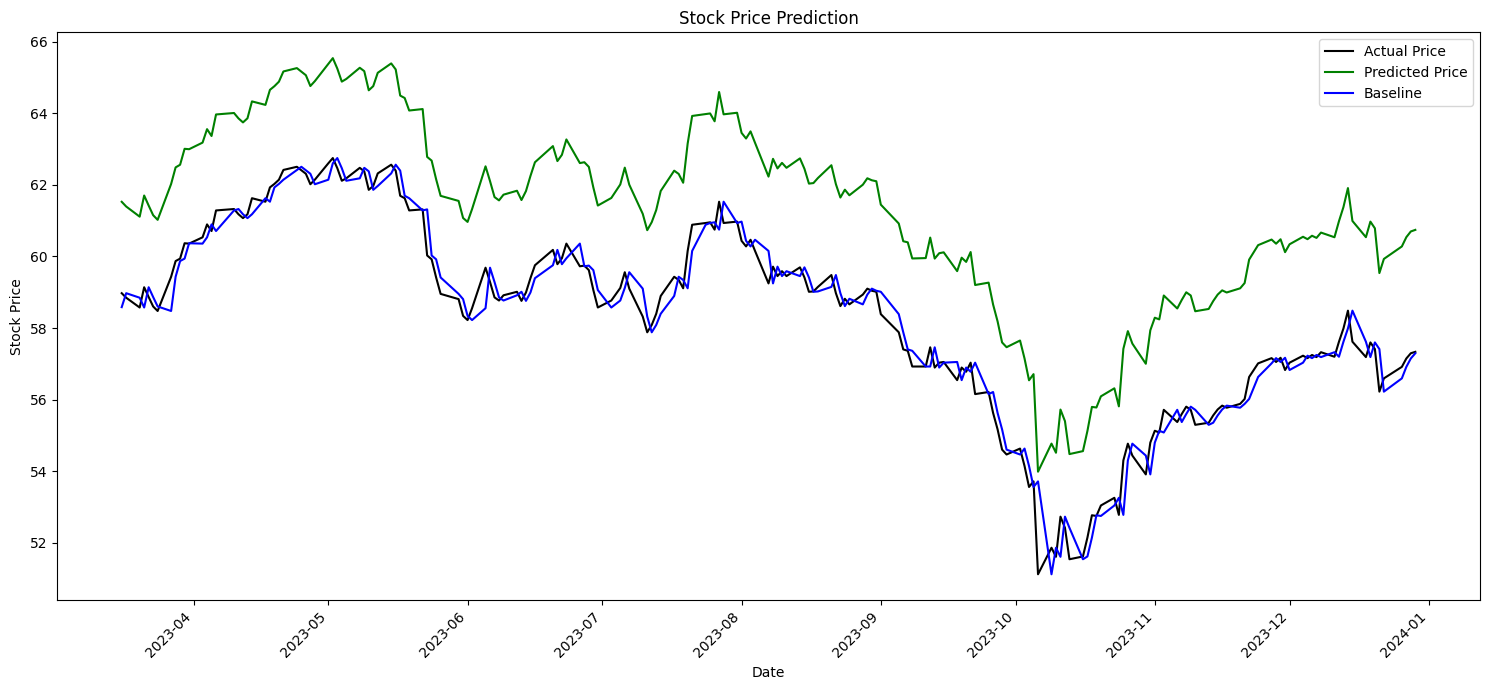

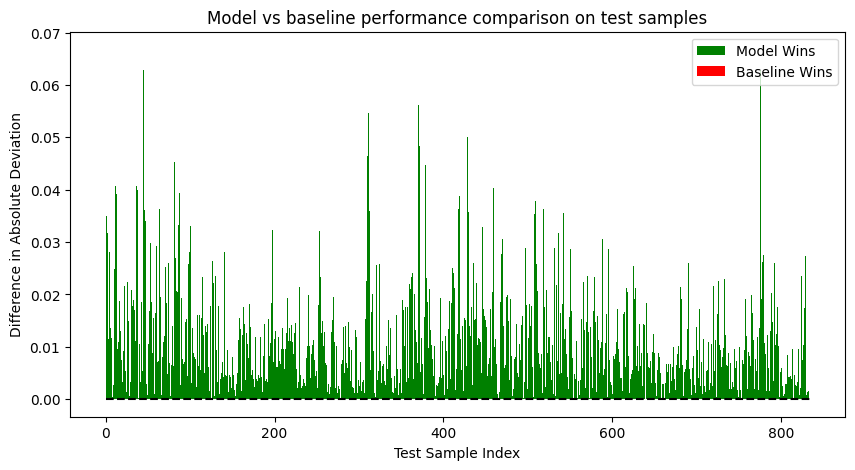

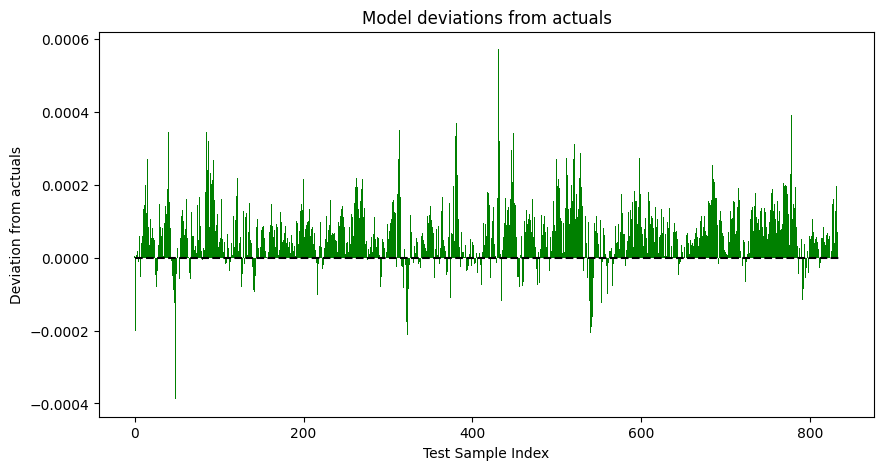

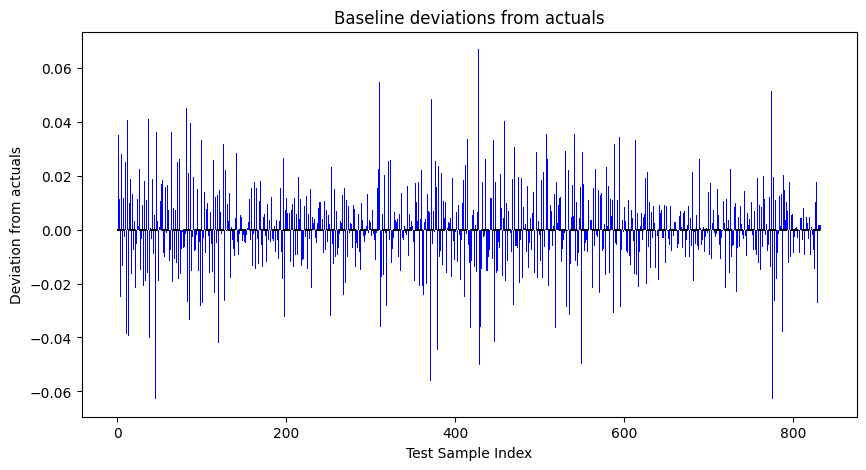

Testing DataLoader 0: 100%|██████████| 14/14 [00:06<00:00,  2.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss         3.7424705112698575e-08
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_loss,▁
train_loss_epoch,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▄▂▂▂▂▁▃▂▂▂▂▂▁▂▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▁▁▂▁▁▃▁▃▁▁▄▁▁▄▁▁▁▅▂▂▂▂▂▂▂▂▂▂▇▂▂▇▂▂██
val_loss_epoch,████▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,▂▂█▂▁█▂▁▂▁▁▂▁▂▁▁▂▁▅▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
test_loss,0.0
train_loss_epoch,0.0
train_loss_step,0.0


In [1]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import wandb
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
from config import num_epochs, learning_rate, wandb_config, model
from preprocessing import stock_df
from preprocessing import train_loader, val_loader, test_loader, label_scaler, test_dates, initial_actual_close

class StockPredictionModule(pl.LightningModule):
    def __init__(self, model, label_scaler, train_loader, val_loader, test_loader, test_dates):
        super().__init__()
        self.model = model
        self.label_scaler = label_scaler
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.test_dates = test_dates
        self.criterion = nn.MSELoss()
        # self.criterion = torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean', label_smoothing=0.0)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self):
        predictions, actuals = [], []
        for seqs, labels in self.test_loader:
            seqs, labels = seqs.to(self.device), labels.to(self.device)
            output = self(seqs)
            predictions.extend(output.view(-1).detach().cpu().numpy())
            actuals.extend(labels.view(-1).detach().cpu().numpy())

        predictions_rescaled = list(self.label_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten())
        actuals_rescaled = list(self.label_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten())
        baseline_rescaled = [actuals_rescaled[0]] + actuals_rescaled[:-1]

        len_test_set = len(predictions)
        actual_closing_prices = stock_df['Close'].values[-(len_test_set):]

        
        # Use plotting with rebasing to visualize the predictions as prices
        rebase_period = 30
        predicted_prices = [actual_closing_prices[0]]
        for i, relative_change in enumerate(predictions_rescaled[1:], 1):
            if i % rebase_period == 0:
                predicted_prices.append(actual_closing_prices[i])
            else:
                predicted_prices.append(predicted_prices[-1] * relative_change)
        baseline_prices = [actual_closing_prices[0]] + list(actual_closing_prices[:-1])

        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(test_dates, actual_closing_prices, label='Actual Price', color='black', linestyle='-')
        ax.plot(test_dates, predicted_prices, label='Predicted Price', color='green', linestyle='-')
        ax.plot(test_dates, baseline_prices, label='Baseline', color='blue', linestyle='-') 
        ax.set_title('Price predictions based on last price in validation set')
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        ax.legend()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
        filename = "plot.png"
        fig.savefig(filename)
        wandb.log({"Stock Price Prediction": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)
        

        """
        actual_prices = [actual_closing_prices[0]]
        for i in range(1, len(actuals_rescaled)):
            actual_prices.append(actual_prices[i-1] * actuals_rescaled[i])
        prediction_prices = [actual_closing_prices[0]]
        for i in range(1, len(predictions_rescaled)):
            prediction_prices.append(prediction_prices[i-1] * predictions_rescaled[i])
        baseline_prices = [actual_prices[0]] + actual_prices[:-1]
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(test_dates, actual_prices, label='Actual Price', color='black', linestyle='-')
        ax.plot(test_dates, prediction_prices, label='Predicted Price', color='green', linestyle='-')
        ax.plot(test_dates, baseline_prices, label='Baseline', color='blue', linestyle='-')
        ax.set_title('Stock Price Prediction')
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        ax.legend()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
        filename = "plot.png"
        fig.savefig(filename)
        wandb.log({"Stock Price Prediction": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)
        """
        
        net_abs_dev = torch.tensor([abs(predictions_rescaled[i] - actuals_rescaled[i]) for i in range(len(actuals_rescaled))])
        baseline_abs_dev = torch.tensor([abs(baseline_rescaled[i] - actuals_rescaled[i]) for i in range(len(actuals_rescaled))])
        diff_pos = torch.relu(baseline_abs_dev - net_abs_dev).reshape(-1).tolist()
        diff_min = (-torch.relu(net_abs_dev - baseline_abs_dev)).reshape(-1).tolist()
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_title('Model vs baseline performance comparison on test samples')
        ax.hlines(0, xmin=0, xmax=len(actuals_rescaled), linestyles='dashed', colors='black')
        ax.bar(list(range(len(actuals_rescaled))), diff_pos, color='g', label='Model Wins', width=1.0)
        ax.bar(list(range(len(actuals_rescaled))), diff_min, color='r', label='Baseline Wins', width=1.0)
        ax.legend()
        ax.set_xlabel('Test Sample Index')
        ax.set_ylabel('Difference in Absolute Deviation')
        plt.show()
        filename = "comparison_plot.png"
        fig.savefig(filename)
        wandb.log({"Model vs Baseline Performance Comparison": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)

        model_actual_dev = torch.tensor([predictions_rescaled[i] - actuals_rescaled[i] for i in range(len(actuals_rescaled))])
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_title('Model deviations from actuals')
        ax.hlines(0, xmin=0, xmax=len(actuals_rescaled), linestyles='dashed', colors='black')
        ax.bar(list(range(len(actuals_rescaled))), model_actual_dev, color='g', label='Model Wins', width=1.0)
        ax.set_xlabel('Test Sample Index')
        ax.set_ylabel('Deviation from actuals')
        plt.show()
        filename = "comparison_plot.png"
        fig.savefig(filename)
        wandb.log({"Model deviations from actuals": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)

        baseline_actual_dev = torch.tensor([baseline_rescaled[i] - actuals_rescaled[i] for i in range(len(actuals_rescaled))])
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_title('Baseline deviations from actuals')
        ax.hlines(0, xmin=0, xmax=len(actuals_rescaled), linestyles='dashed', colors='black')
        ax.bar(list(range(len(actuals_rescaled))), baseline_actual_dev, color='b', label='Baseline Wins', width=1.0)
        ax.set_xlabel('Test Sample Index')
        ax.set_ylabel('Deviation from actuals')
        plt.show()
        filename = "comparison_plot.png"
        fig.savefig(filename)
        wandb.log({"Baseline deviations from actuals": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)

        actuals_rescaled = np.array(actuals_rescaled)
        predictions_rescaled = np.array(predictions_rescaled)
        baseline_rescaled = np.array(baseline_rescaled)

        model_mse = mean_squared_error(actuals_rescaled, predictions_rescaled)
        model_rmse = np.sqrt(model_mse)
        model_mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
        model_r2 = r2_score(actuals_rescaled, predictions_rescaled)
        model_mape = np.mean(np.abs((actuals_rescaled - predictions_rescaled) / (actuals_rescaled + 1e-8)))
        
        baseline_mse = mean_squared_error(actuals_rescaled, baseline_rescaled)
        baseline_rmse = np.sqrt(baseline_mse)
        baseline_mae = mean_absolute_error(actuals_rescaled, baseline_rescaled)
        baseline_r2 = r2_score(actuals_rescaled, baseline_rescaled)
        baseline_mape = np.mean(np.abs((actuals_rescaled - baseline_rescaled) / (actuals_rescaled + 1e-8)))

        model_metrics = {
            "mse": model_mse,
            "rmse": model_rmse,
            "mae": model_mae,
            "mape": model_mape,
            "r2": model_r2,
        }

        baseline_metrics = {
            "mse": baseline_mse,
            "rmse": baseline_rmse,
            "mae": baseline_mae,
            "mape": baseline_mape,
            "r2": baseline_r2,
        }

        model_baseline_performance_metrics = {
            "mse": round((baseline_mse / model_mse - 1) * 100, 2),
            "rmse": round((baseline_rmse / model_rmse - 1) * 100, 2),
            "mae": round((baseline_mae / model_mae - 1) * 100, 2),
            "mape": round((baseline_mape / model_mape - 1) * 100, 2),
            "r2": round((model_r2 / baseline_r2 - 1) * 100, 2),
        }

        metrics_table = wandb.Table(columns=["metric", "model", "baseline", "model-baseline performance comparison [%]"])
        for metric in model_metrics.keys():
            metrics_table.add_data(metric, model_metrics[metric], baseline_metrics[metric], model_baseline_performance_metrics[metric])
        wandb.log({"metrics": metrics_table})

def main():
    torch.set_float32_matmul_precision("medium")
    wandb_logger = WandbLogger(project="RNN_single_step_forecasts", log_model="all", config=wandb_config)
    # train_loader, val_loader, test_loader, label_scaler, test_dates = load_data()
    
    module = StockPredictionModule(model=model, label_scaler=label_scaler,
                                   train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, test_dates = test_dates)

    # Device agnostic initialization
    if torch.cuda.is_available():   # Check for GPU availability
        accelerator = "gpu"
        devices = 1
    elif hasattr(torch, 'has_mps') and torch.backends.mps.is_built():  # Check for MPS availability (Apple Silicon)
        accelerator = "mps"
        devices = 1
    else:
        accelerator = None  # Defaults to CPU
        devices = None  # Ignored for CPU

    trainer = Trainer(max_epochs=num_epochs, logger=wandb_logger, accelerator=accelerator, devices=devices, enable_checkpointing=True)
    trainer.fit(module, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.test(dataloaders=test_loader, ckpt_path="best")

    wandb.finish()

if __name__ == "__main__":
    main()



In [ ]:
# pip install optuna

# Hyperparamter tuning

import optuna
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_size = trial.suggest_int('hidden_size', 16, 128)

    # Update model config
    model_config.update({
        "hidden_layer_size": hidden_size,
        "num_layers": num_layers
    })

    # Create the model with new hyperparameters
    model = RNNModel(**model_config)

    # Setup data
    train_loader, val_loader, _, _, _, _, _ = load_data()

    # Create the PyTorch Lightning module
    pl_module = StockPredictionModule(model=model, optimizer=torch.optim.Adam, learning_rate=learning_rate)

    # Trainer setup with Early Stopping
    trainer = Trainer(
        logger=False,
        checkpoint_callback=False,
        max_epochs=50,
        callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=10)],
        progress_bar_refresh_rate=0
    )
    
    # Training the model
    trainer.fit(pl_module, train_loader, val_loader)

    # Evaluate the model
    val_result = trainer.validate(pl_module, val_dataloaders=val_loader, verbose=False)
    val_loss = val_result[0]['val_loss']

    return val_loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_trial.params)

In [ ]:
from preprocessing import stock_df, labels
print(labels)

In [ ]:
from preprocessing import columns
print(str(columns.tolist()))